# Travel Recommendation System

## Overview

This project builds a Travel Recommendation System using real-world datasets to suggest personalized travel destinations and packages. The objective is to improve recommendation relevance using data-driven techniques.

The following approaches are implemented and compared:
- Content-Based Filtering
- Collaborative Filtering
- Hybrid Recommendation Model

---

## Step 1: Import Libraries and Load Data

In this step, the required Python libraries are imported and datasets are loaded into Pandas DataFrames. 

Initial data exploration is performed to understand structure, detect missing values, and prepare the data for feature engineering and model development.


In [126]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [102]:
# Load Datasets

# Get project root dynamically
BASE_DIR = Path().resolve().parent   
DATA_PATH = BASE_DIR / "data" / "raw" 

destinations_df = pd.read_csv(DATA_PATH / "destinations.csv")
reviews_df = pd.read_csv(DATA_PATH / "reviews.csv")
user_history_df = pd.read_csv(DATA_PATH / "user_history.csv")
users_df = pd.read_csv(DATA_PATH / "users.csv")


In [103]:
destinations_df.sample(5)

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
346,347,Goa Beaches,Goa,Beach,7.920960,Nov-Mar
817,818,Jaipur City,Rajasthan,City,8.385707,Oct-Mar
874,875,Leh Ladakh,Jammu and Kashmir,Adventure,8.982970,Apr-Jun
834,835,Leh Ladakh,Jammu and Kashmir,Adventure,8.622268,Apr-Jun
925,926,Taj Mahal,Uttar Pradesh,Historical,8.324742,Nov-Feb


In [104]:
reviews_df.sample(5)

,ReviewID,DestinationID,UserID,Rating,ReviewText
500,501,501,53,5,A historical wonder
965,966,935,454,1,A historical wonder
495,496,955,697,4,Incredible monument!
478,479,990,111,5,Loved the beaches!
356,357,52,73,1,A historical wonder


In [105]:
user_history_df.sample(5)

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
110,111,132,839,2024-03-20,5
620,621,239,690,2024-03-20,5
943,944,271,767,2024-02-15,2
133,134,148,301,2024-02-15,2
712,713,50,114,2024-02-15,3


In [106]:
users_df.sample(5)

,UserID,Name,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
887,888,Riya,riya@example.com,"City, Historical",Female,2,0
503,504,Isha,isha@example.com,"City, Historical",Female,1,1
697,698,Hitesh,hitesh@example.com,"Nature, Adventure",Male,1,2
353,354,Meera,meera@example.com,"City, Historical",Female,1,2
184,185,Meera,meera@example.com,"Nature, Adventure",Female,2,1


In [107]:
# Merge datasets step-by-step

# Step 1: Merge reviews with destinations on 'DestinationID'
reviews_destinations = pd.merge(reviews_df, destinations_df, on='DestinationID', how='inner')

# Step 2: Merge the result with user history on 'UserID'
reviews_destinations_user_history = pd.merge(reviews_destinations, user_history_df, on='UserID', how='inner')

# Step 3: Merge the result with users on 'UserID'
df = pd.merge(reviews_destinations_user_history, users_df, on='UserID',how='inner')

df.sample(5)


,ReviewID,DestinationID_x,UserID,Rating,ReviewText,Name_x,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,Name_y,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
835,823,415,878,4,Incredible monument!,Leh Ladakh,Jammu and Kashmir,Adventure,8.650438,Apr-Jun,243,421,2024-03-20,3,Meera,meera@example.com,"Nature, Adventure",Female,1,2
780,752,576,524,5,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.450302,Nov-Feb,115,476,2024-01-01,5,Diya,diya@example.com,"Nature, Adventure",Female,2,2
851,835,668,794,3,Incredible monument!,Jaipur City,Rajasthan,City,7.593850,Oct-Mar,305,853,2024-02-15,4,Meera,meera@example.com,"Nature, Adventure",Female,2,1
641,617,652,798,2,Loved the beaches!,Goa Beaches,Goa,Beach,7.956163,Nov-Mar,742,975,2024-01-01,5,Rohan,rohan@example.com,"City, Historical",Male,2,1
158,166,770,752,1,Incredible monument!,Leh Ladakh,Jammu and Kashmir,Adventure,9.081030,Apr-Jun,975,799,2024-03-20,3,Vivaan,vivaan@example.com,"Nature, Adventure",Male,1,2


# Step 2: Data Preprocessing 

We will clean and preprocess the data to make it ready for building recommendation models.

In [108]:
# Removing duplicate records
df.drop_duplicates(inplace=True) 

# Removing the repeated columns after merge and renaming
df = df.drop(columns=[col for col in df.columns if col.endswith('_y')])
df = df.rename(columns=lambda x: x.replace('_x', ''))

df.shape

(993, 18)

In [109]:
# Get project root dynamically
BASE_DIR = Path().resolve().parent   
DATA_PATH = BASE_DIR / "data" / "processed" 

df.to_csv(DATA_PATH / "final_df.csv", index=False)

## Step 2.1: Visualization

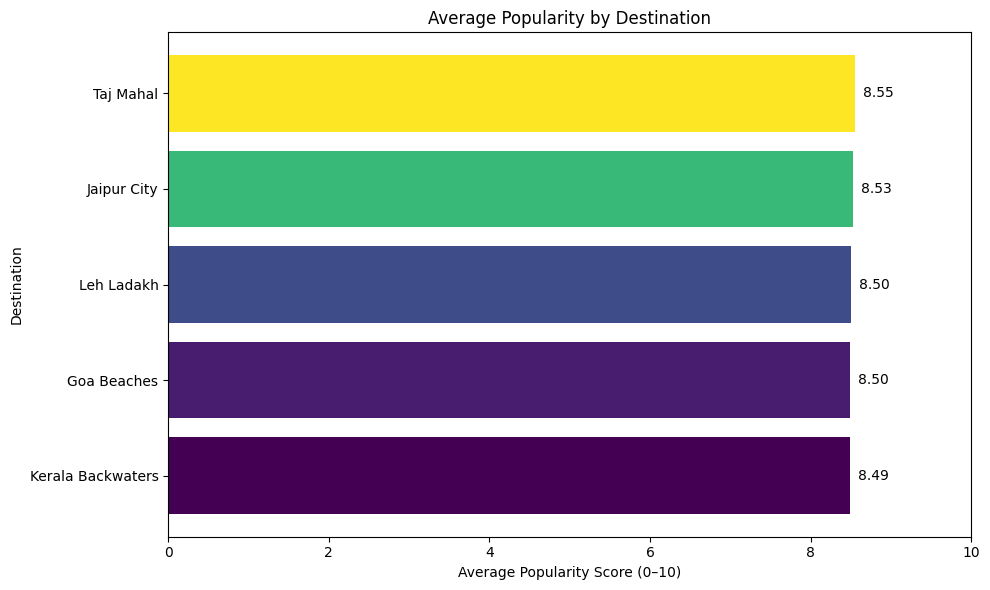

In [110]:

# Aggregate data
df_agg = (
    destinations_df
    .groupby("Name", as_index=False)
    .agg({"Popularity": "mean"})
    .sort_values("Popularity", ascending=True)
)

plt.figure(figsize=(10, 6))

# Create gradient colors based on popularity
norm = plt.Normalize(df_agg["Popularity"].min(), df_agg["Popularity"].max())
colors = plt.cm.viridis(norm(df_agg["Popularity"]))

ax = plt.barh(
    df_agg["Name"],
    df_agg["Popularity"],
    color=colors
)

plt.xlim(0, 10)
plt.xlabel("Average Popularity Score (0–10)")
plt.ylabel("Destination")
plt.title("Average Popularity by Destination")

# Add value labels
for i, v in enumerate(df_agg["Popularity"]):
    plt.text(v + 0.1, i, f"{v:.2f}", va='center')

plt.tight_layout()
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_8836\2370472049.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Type', data=destinations_df, order=destinations_df['Type'].value_counts().index, palette='coolwarm')


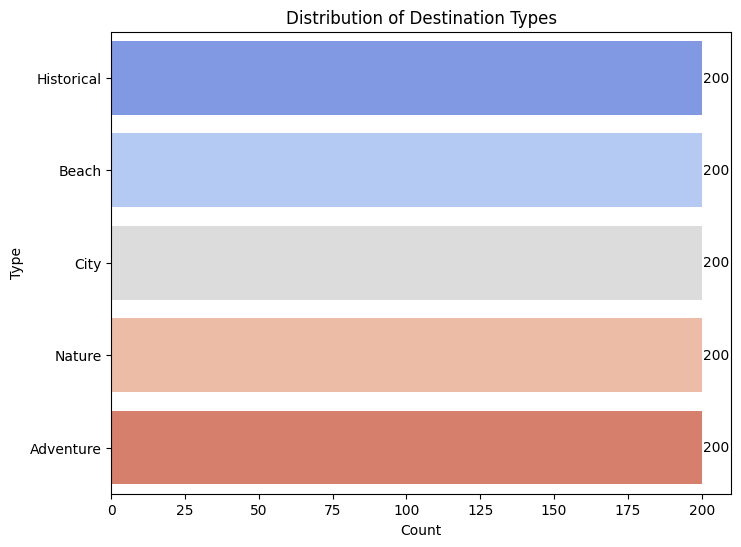

In [111]:
# 2. Destination Types Distribution

plt.figure(figsize=(8,6))
ax = sns.countplot(y='Type', data=destinations_df, order=destinations_df['Type'].value_counts().index, palette='coolwarm')

# Add numbers on bars
for container in ax.containers:
    ax.bar_label(container, padding=1)
    
plt.title('Distribution of Destination Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_8836\2009382187.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='BestTimeToVisit', data=destinations_df, order=destinations_df['BestTimeToVisit'].value_counts().index, palette='mako')


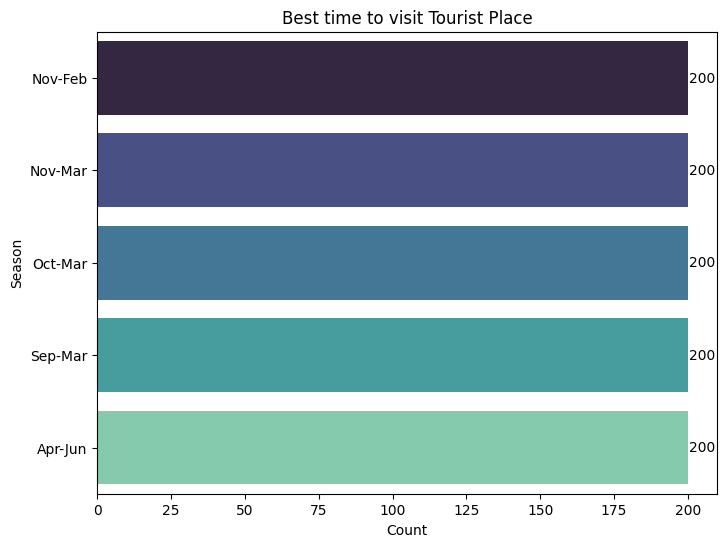

In [112]:
# 3. Best Time to Visit Distribution

plt.figure(figsize=(8,6))
ax = sns.countplot(y='BestTimeToVisit', data=destinations_df, order=destinations_df['BestTimeToVisit'].value_counts().index, palette='mako')

for container in ax.containers:
    ax.bar_label(container, padding=1)
    
plt.title('Best time to visit Tourist Place')
plt.xlabel('Count')
plt.ylabel('Season')
plt.show()


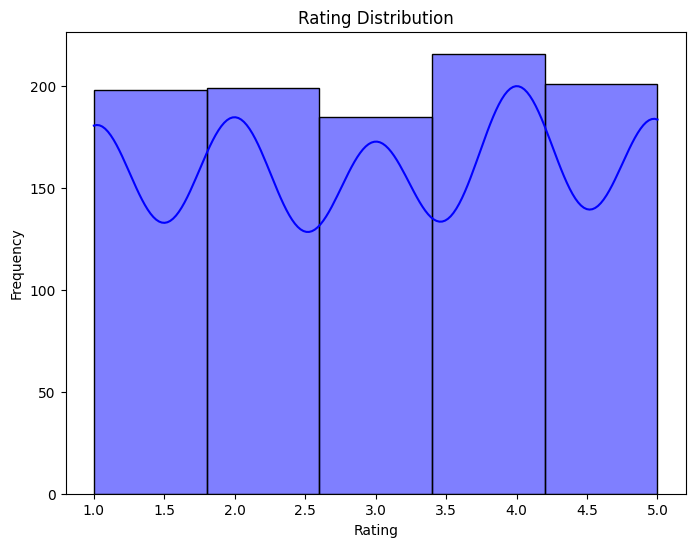

In [113]:
# 4. Ratings Distribution

plt.figure(figsize=(8,6))
sns.histplot(reviews_df['Rating'], bins=5, kde=True, color='blue')

plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

# Step 3: Content-Based Recommendation Model

Content-based recommendations suggest destinations based on the attributes of destinations that match a user’s interests.  

- **Type**
- **Preferences**

----

## Step 3.1: Prepare Destination Features

To build a content-based filtering system, we need to  use the following columns to create features.

- **Type**
- **State**
- **BestTimeToVisit**
- **Preferences**

### Approach:

1. Select relevant feature columns.
2. Combine them into a single textual representation.
3. Convert the combined text into numerical vectors using TF-IDF.
4. Use these vectors to compute similarity between destinations.

In [114]:
# Create a text-based feature for the destinations
df['features'] = df['Type'] + ' ' + df['State'] + ' ' + df['BestTimeToVisit'] + ' ' + df['Preferences']

# Apply TF-IDF vectorizer to create feature vectors for destinations
vectorizer = TfidfVectorizer(stop_words='english')
destination_features = vectorizer.fit_transform(df['features'])

# Compute cosine similarity between destinations
cosine_sim = cosine_similarity(destination_features, destination_features)

## Step 3.2: Recommendation Function

Based on the cosine similarity matrix, we can build a recommendation function that suggests destinations similar to the ones the user has liked in the past.

---

### How It Works

1. Take the destination selected by the user.
2. Find its index in the dataset.
3. Retrieve similarity scores for that destination from the cosine similarity matrix.
4. Sort destinations by similarity score in descending order.
5. Recommend the top 5 most similar destinations (excluding the selected one).

---

In [115]:
# Define recommendation function
def recommend_destinations(user_id, user_history_df, destinations_df, cosine_sim):
    """
    Recommends top 5 destinations for a given user based on similarity scores.

    Args:
    - user_id: ID of the user.
    - user_history_df: User history DataFrame containing 'UserID' and 'DestinationID'.
    - destinations_df: Destinations DataFrame containing destination details.
    - cosine_sim: Cosine similarity matrix for destinations.

    Returns:
    - DataFrame with recommended destinations and their details.
    """   
    
    # Get the destinations the user has visited
    visited_destinations = user_history_df[user_history_df['UserID'] == user_id]['DestinationID'].values
        
    # Calculate similarity scores for visited destinations
    similar_scores = np.sum(cosine_sim[visited_destinations - 1], axis=0)
    
    # Recommend the top 5 destinations the user hasn't visited yet
    recommended_destination_idx = np.argsort(similar_scores)[::-1]
    
    recommendations = []
    
    for idx in recommended_destination_idx:
        if destinations_df.iloc[idx]['DestinationID'] not in visited_destinations:
            # Append detailed information for each recommendation
            recommendations.append(destinations_df.iloc[idx][[
                'DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
            ]].to_dict())
            
        if len(recommendations) >= 5:
            break
    
    # Convert recommendations to a DataFrame
    return pd.DataFrame(recommendations)   
   

In [116]:
# Example: Recommend destinations for user with ID 10
recommended_destinations = recommend_destinations(50, user_history_df, destinations_df, cosine_sim)

# Display recommendations
recommended_destinations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
0,639,Kerala Backwaters,Kerala,Nature,9.081926,Sep-Mar
1,62,Goa Beaches,Goa,Beach,9.379787,Nov-Mar
2,638,Jaipur City,Rajasthan,City,9.315120,Oct-Mar
3,610,Leh Ladakh,Jammu and Kashmir,Adventure,7.940661,Apr-Jun
4,63,Jaipur City,Rajasthan,City,9.202094,Oct-Mar


# Step 4: Collaborative Filtering

In collaborative filtering, we recommend destinations based on the behavior and preferences of similar users.

#### Step 4.1: Create a User-Item Matrix

We create a matrix where:

- Rows represent **users**
- Columns represent **destinations**
- Values represent **ratings or interactions**

This matrix helps identify similarities between users (user-based filtering) or between destinations (item-based filtering) to generate personalized recommendations.

In [117]:
# Create a user-item matrix based on user history
user_item_matrix = user_history_df.pivot(index='UserID', columns='DestinationID', values='ExperienceRating')

# Fill missing values with 0 (indicating no rating/experience)
user_item_matrix.fillna(0, inplace=True)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

#### Step 4.2: Cosine Similarity Between Users
We will create collaborative recommendation function based on the user-item matrix

In [118]:
def collaborative_recommendation(user_id, user_similarity, user_item_matrix, destinations_df):
    """
    Recommends destinations based on collaborative filtering.

    Args:
    - user_id: ID of the user for whom recommendations are to be made.
    - user_similarity: Cosine similarity matrix for users.
    - user_item_matrix: User-item interaction matrix (e.g., ratings or preferences).
    - destinations_df: DataFrame containing destination details.

    Returns:
    - DataFrame with recommended destinations and their details.
    """
    
    #  Get the top 5 most similar users by excluding yourself
    similar_users = user_similarity[user_id - 1]        
    similar_user_idx = np.argsort(similar_users)[::-1][1:6]
    
    # Get the destinations liked by similar users
    similar_users_ratings = user_item_matrix.iloc[similar_user_idx].mean(axis=0)
    
    # Recommend the top 5 destinations
    recommend_destinations_ids = similar_users_ratings.sort_values(ascending=False).head(5).index
    
    # Filter the destinations DataFrame to include detailed information
    recommendations = destinations_df[destinations_df['DestinationID'].isin(recommend_destinations_ids)][[
        'DestinationID', 'Name', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
    ]]
    
    return recommendations    

In [119]:
# Example: Collaborative recommendations for user 11
collaborative_recommendations = collaborative_recommendation(11, user_similarity, user_item_matrix, destinations_df)

# Display recommendations
collaborative_recommendations

,DestinationID,Name,State,Type,Popularity,BestTimeToVisit
300,301,Taj Mahal,Uttar Pradesh,Historical,8.634309,Nov-Feb
345,346,Taj Mahal,Uttar Pradesh,Historical,8.969951,Nov-Feb
367,368,Jaipur City,Rajasthan,City,8.008252,Oct-Mar
724,725,Leh Ladakh,Jammu and Kashmir,Adventure,9.339552,Apr-Jun
969,970,Leh Ladakh,Jammu and Kashmir,Adventure,9.013101,Apr-Jun


# Step 6 User input feature base recommendation

In [120]:
# Load and preprocess the data

# Get project root dynamically
BASE_DIR = Path().resolve().parent   
DATA_PATH = BASE_DIR / "data" / "processed" 

data = pd.read_csv(DATA_PATH / 'final_df.csv')

In [ ]:
# Select relevant features
features = ['Name', 'State', 'Type', 'BestTimeToVisit', 'Preferences', 'Gender', 'NumberOfAdults', 'NumberOfChildren']
target = ['Popularity']

# Encode Categorical Values
label_encoders = {}

for col in features:    
    if data[col].dtype == 'str':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        
   
# Split the dataset
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")
print(label_encoders)    


c:\Users\DELL\Downloads\Travel_Recommender_System\.venv\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 0.30
R2 Score: 0.07
{'Name': LabelEncoder(), 'State': LabelEncoder(), 'Type': LabelEncoder(), 'BestTimeToVisit': LabelEncoder(), 'Preferences': LabelEncoder(), 'Gender': LabelEncoder()}


In [ ]:
# Prediction System
def popularity_prediction(user_input, model, label_encoders, features, data):
    # Encode user input
    encoded_input = {}
    
    for feature in features:
        if feature in label_encoders:
            encoded_input[feature] = label_encoders[feature].transform([user_input[feature]])[0]
            cnt += 1
        else:
            encoded_input[feature] = user_input[feature]
    
    # Convert to Dataframe
    input_df = pd.DataFrame([encoded_input])
    
    # Predict Popularity
    predicted_popularity = model.predict(input_df)[0]
    
    return predicted_popularity

In [125]:
# Example user input
user_input = {
    'Name': 'Jaipur City',
    'Type': 'City',
    'State': 'Rajasthan',
    'BestTimeToVisit': 'Oct-Mar',  # This might be an unseen label
    'Preferences': 'City, Historical',
    'Gender': 'Female',
    'NumberOfAdults': 2,
    'NumberOfChildren': 1,
}

# Make a prediction
predicted_popularity = popularity_prediction(user_input, model, label_encoders, features, data)

# Print the predicted popularity and the recommended destination details
print(f"Predicted Popularity Score: {predicted_popularity:.2f}")

6
Predicted Popularity Score: 7.88


In [129]:
# Get project root dynamically

BASE_DIR = Path().resolve().parent   
MODEL_PATH = BASE_DIR / "models" 

pickle.dump(model, open(MODEL_PATH / 'model.pkl', 'wb'))
pickle.dump(label_encoders, open(MODEL_PATH / 'label_encoders.pkl', 'wb'))